In [13]:
# -*- coding: utf-8 -*-

import pandas as pd
import numpy as np
from sklearn import cluster
from hmmlearn import hmm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import copy
from sklearn import preprocessing
import datetime

In [14]:
def load_price_pattern_data(future, pricepointnum, testsize):
    pricedata = pd.read_csv(future + '_min_price.csv')
    volumedata = pd.read_csv(future + '_min_volume.csv')
    table = pd.read_csv(future + '_rank_sum.csv')
    if len(table.index) != len(pricedata.columns) or len(table.index) != len(volumedata.columns):
        print(future + ' Bad Data Length!')
    
    length = len(pricedata.columns)
    pattern = np.zeros((length, pricepointnum + 2))
                       
    for i in range(length):
        tabletradedate = ''.join(table['交易日'][i].split('-'))
        if tabletradedate != pricedata.columns[i] or tabletradedate != volumedata.columns[i]:
            print(future + ' Bad Trade Date!')
            print(table['交易日'][i].strip().strip('-') + ', ' + pricedata.columns[i] + ', ' + volumedata.columns[i])
        tradedate = pricedata.columns[i]
        pricelist = np.array(pricedata[tradedate].dropna())
        volumelist = np.array(volumedata[tradedate].dropna())
        if len(pricelist) != len(volumelist):
            print('Bad Volume Length!')
        
        #将价格序列分成pricepointnum段
        steplen = float(len(pricelist)) / float(pricepointnum)
        checklist = []
        for j in range(pricepointnum):
            checklist.append(min(len(pricelist) - 1, int(round(steplen * (j + 1)))))
        
        pvsum = 0.0
        vsum = 0.0
        intradayprice = [table['昨收价'][i], table['开盘价'][i]]
        for j in range(len(pricelist)):
            #成交量这里加上1防止全是0的话会在求加权价的时候产生除零错误
            pvsum += pricelist[j] * (volumelist[j] + 1.0)
            vsum += (volumelist[j] + 1.0)
            if j in checklist:
                if vsum == 0:
                    print('Bad 0!')
                intradayprice.append(pvsum / vsum)
                pvsum = 0.0
                vsum = 0.0
        intradayprice.append(table['收盘价'][i])
        
        for j in range(pricepointnum + 2):
            pattern[i, j] = (intradayprice[j + 1] - intradayprice[j]) / intradayprice[j]
    #print(pattern[:-testsize])
    #print(pattern[-testsize:])
    return pattern[:-testsize], pattern[-testsize:]

In [15]:
def normalise_cluster(data, num):
    datanormal = copy.deepcopy(data)
    scaler = preprocessing.QuantileTransformer(output_distribution='normal')
    scaler = scaler.fit(datanormal)
    datanormal = scaler.transform(datanormal)
    model = cluster.KMeans(n_clusters=num, n_init = 10, max_iter = 300, tol = 0.00001).fit(datanormal)
    labels  = model.predict(datanormal)
    
    num_of_labels = np.zeros(LabelNum)
    for i in range(len(labels)):
        num_of_labels[labels[i]] += 1
        
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize = (16, 9))
    axs.bar([str(i) for i in range(LabelNum)], num_of_labels)
    axs.set_xlabel(u'Label')
    axs.set_ylabel(u'Count')
    axs.set_title(future + u' Label Count')
    plt.show()
        
    return model, scaler

In [16]:
def k_means(future, data, price, num, showplot):
    datanormal = copy.deepcopy(data)
    scaler = preprocessing.QuantileTransformer(output_distribution='normal')
    scaler = scaler.fit(datanormal)
    datanormal = scaler.transform(datanormal)
    model = cluster.KMeans(n_clusters=num, n_init = 10, max_iter = 300, tol = 0.00001).fit(datanormal)
    labels  = model.predict(datanormal)
    ret_of_labels = np.zeros(LabelNum)
    num_of_labels = np.zeros(LabelNum)
    for i in range(len(labels)):
        ret_of_labels[labels[i]] += price[i]
        num_of_labels[labels[i]] += 1

    names_of_labels = []
    for i in range(LabelNum):
        names_of_labels.append(str(i))
        
    if showplot:
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (16, 9))
        axs[0].bar(names_of_labels, num_of_labels)
        axs[0].set_xlabel(u'Label')
        axs[0].set_ylabel(u'Count')
        axs[0].set_title(future + u' Label Count')
        axs[1].bar(names_of_labels, np.true_divide(ret_of_labels, num_of_labels))
        axs[1].set_xlabel(u'Label')
        axs[1].set_ylabel(u'Average Return')
        axs[1].set_title(future + u' Label Average Return')
        plt.show()
    return labels

In [17]:
def multi_plot(data, plotlabels, x_name, y_name, title):
    if not (len(data) == len(plotlabels)):
        print(u'Bad Plot Length!')
        return
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize = (16, 9))
    for i in range(len(data)):
        axs.plot(range(len(data[i].T)), data[i].T, label = plotlabels[i])
    plt.legend()
    axs.set_xlabel(x_name)
    axs.set_ylabel(y_name)
    axs.set_title(title)
    plt.show()

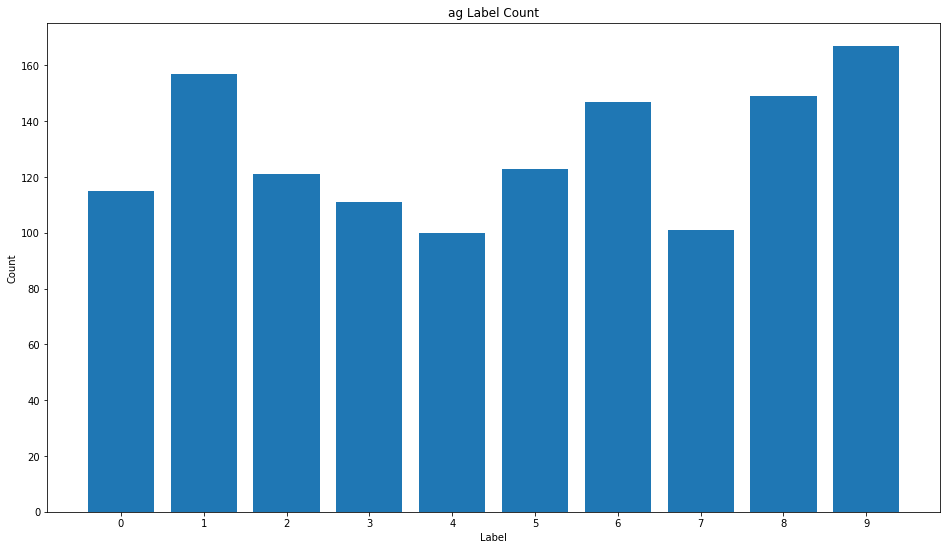

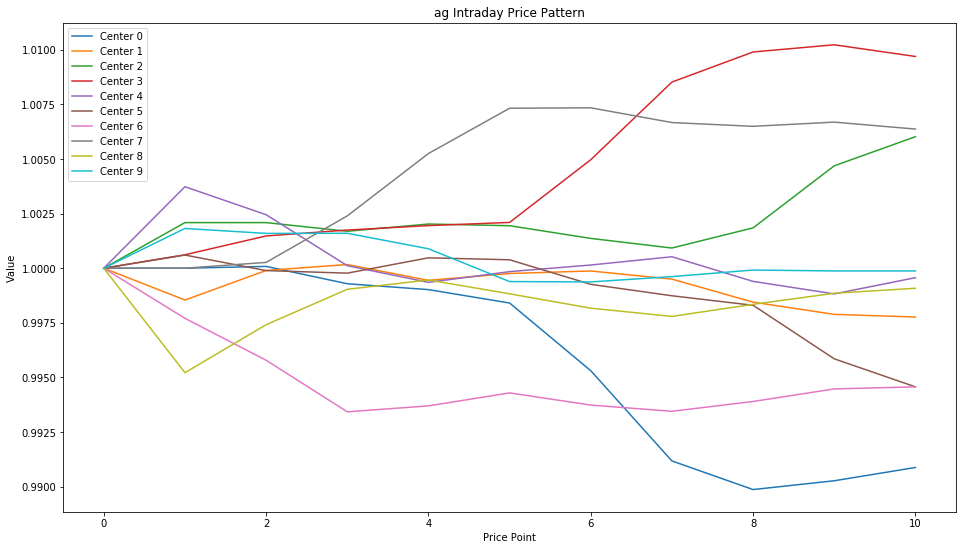

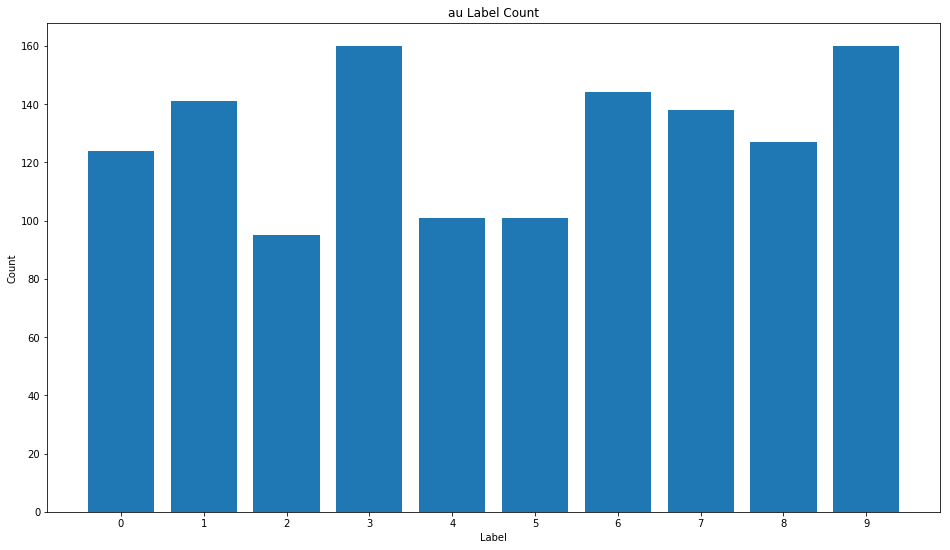

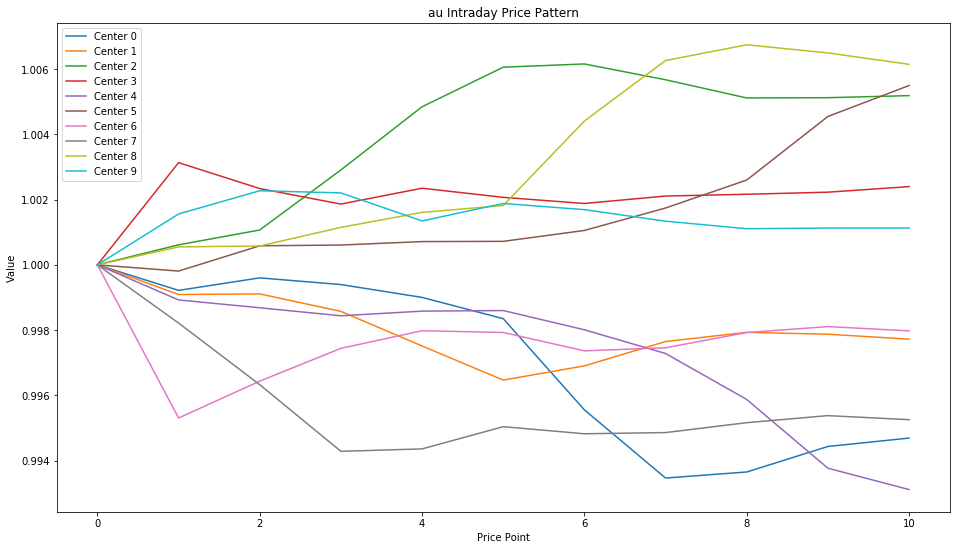

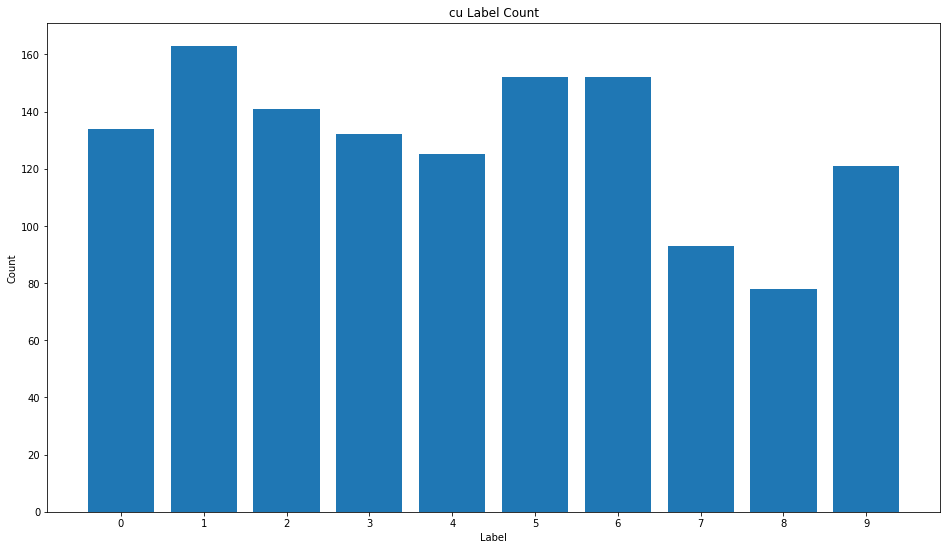

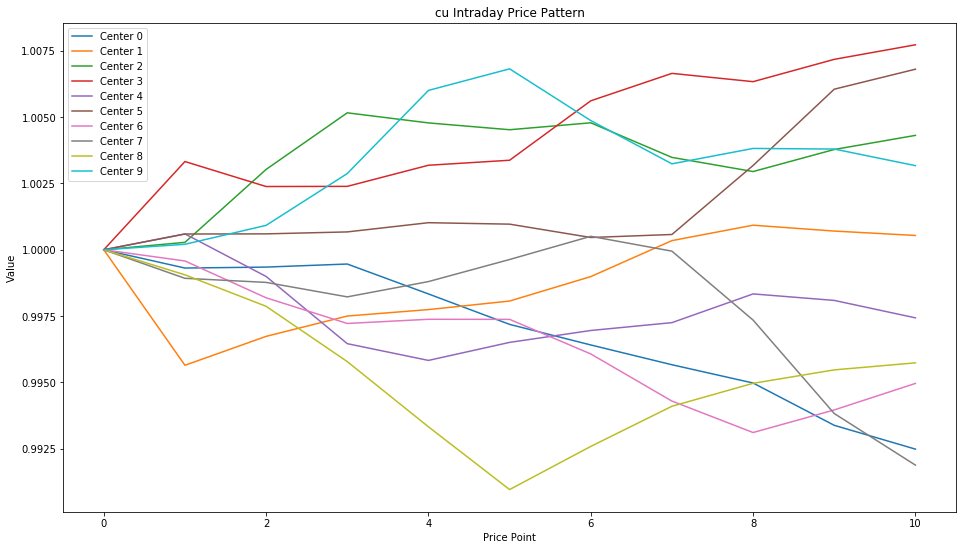

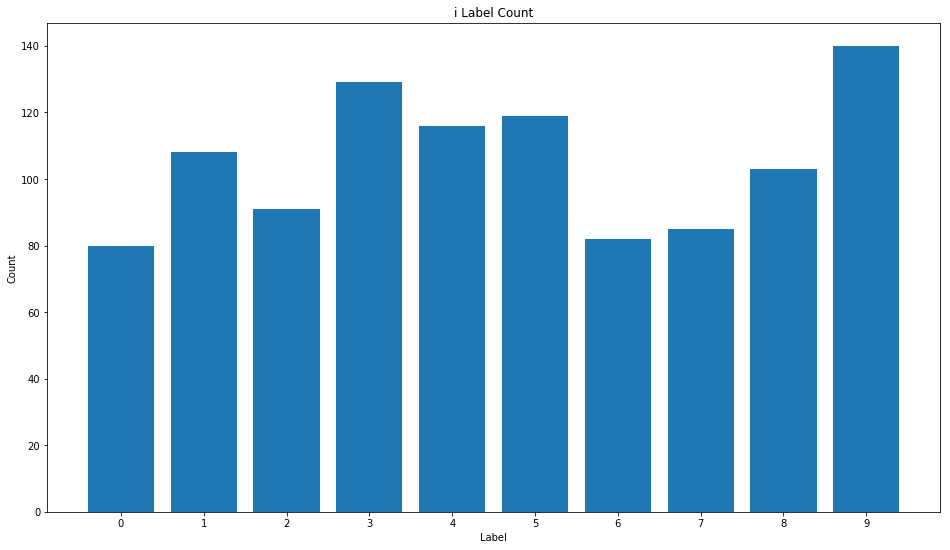

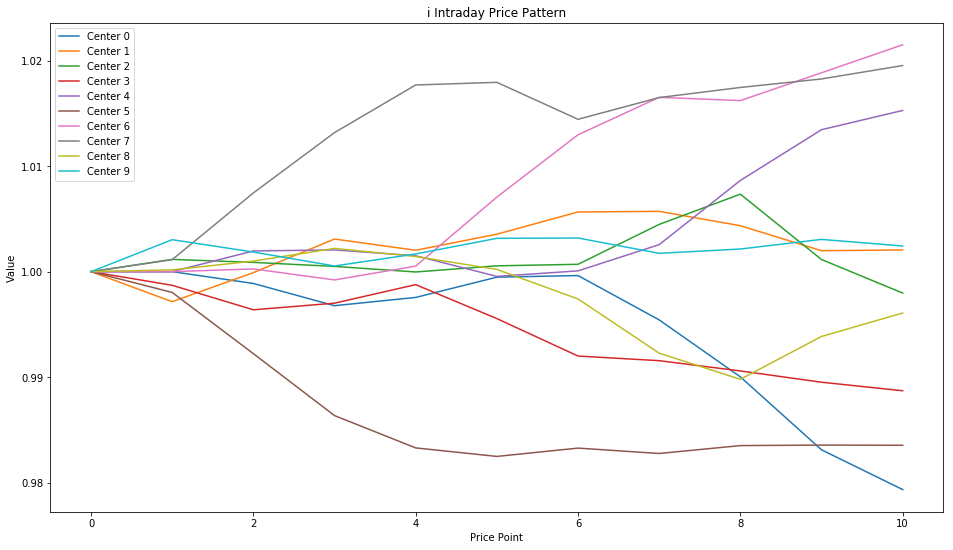

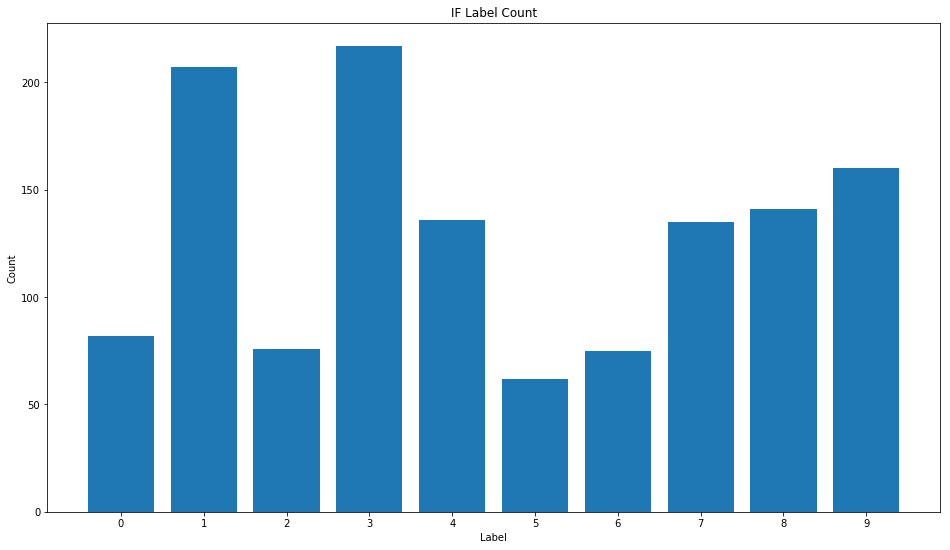

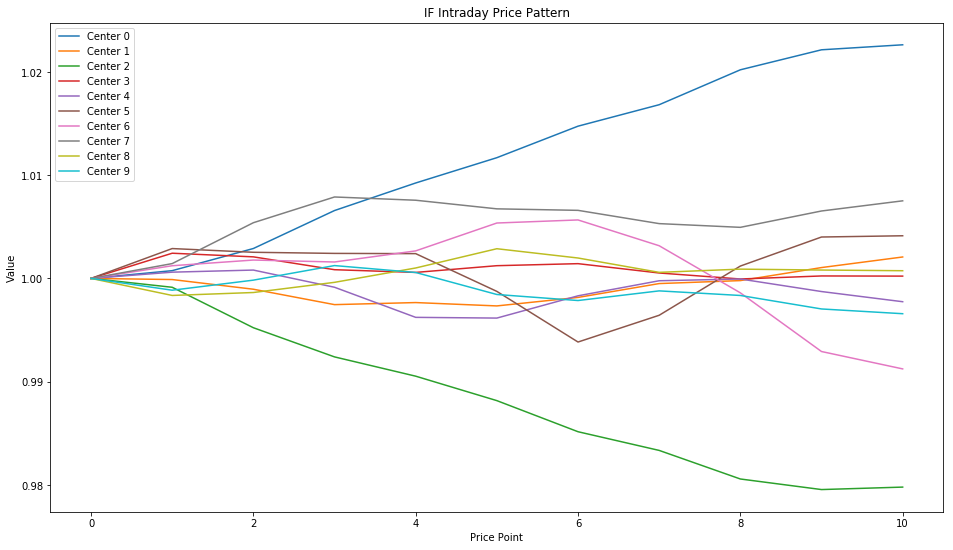

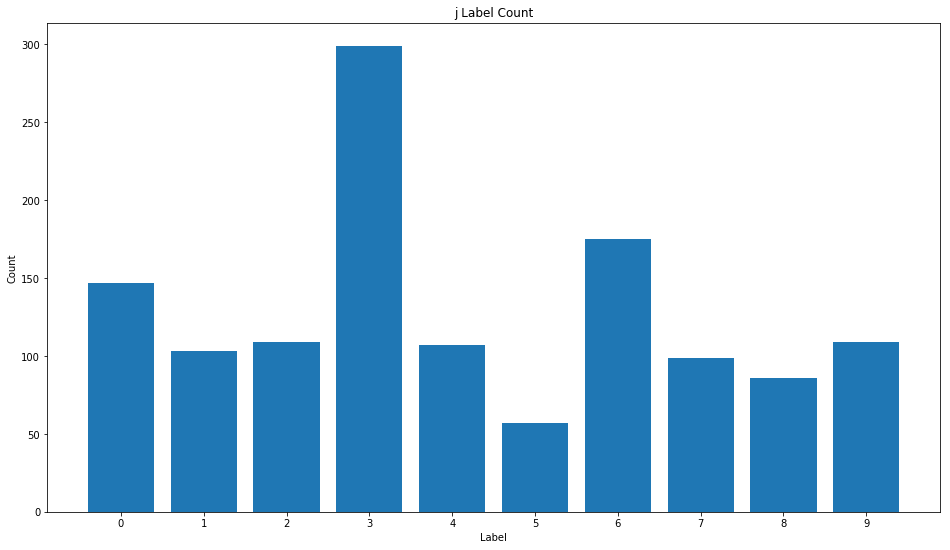

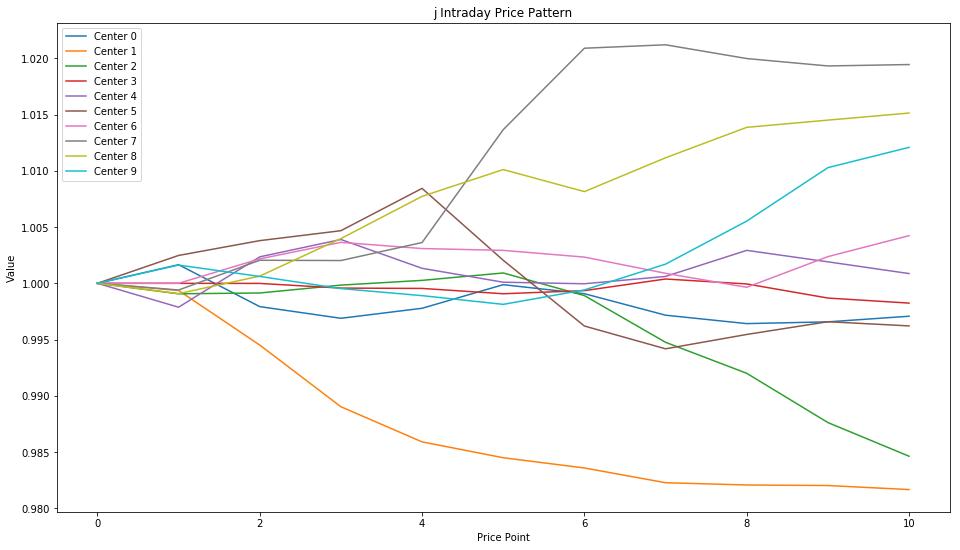

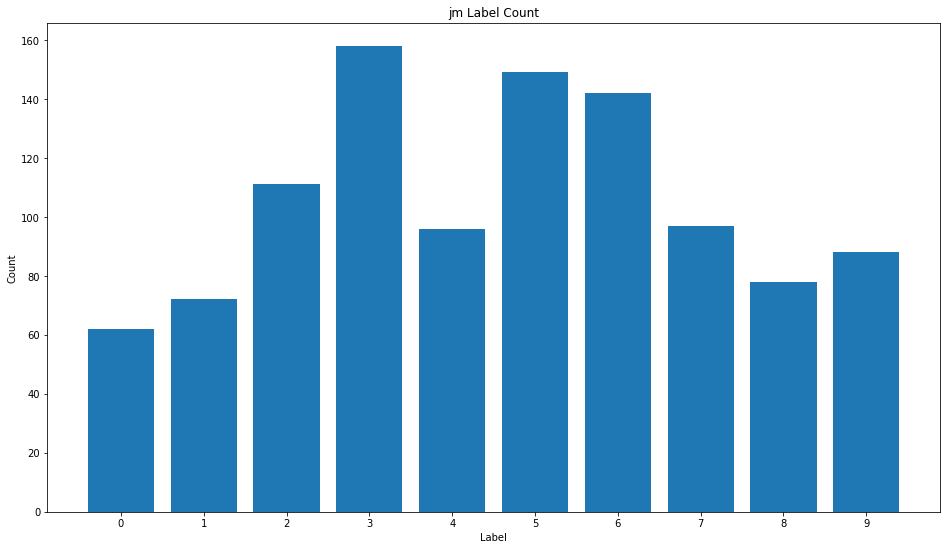

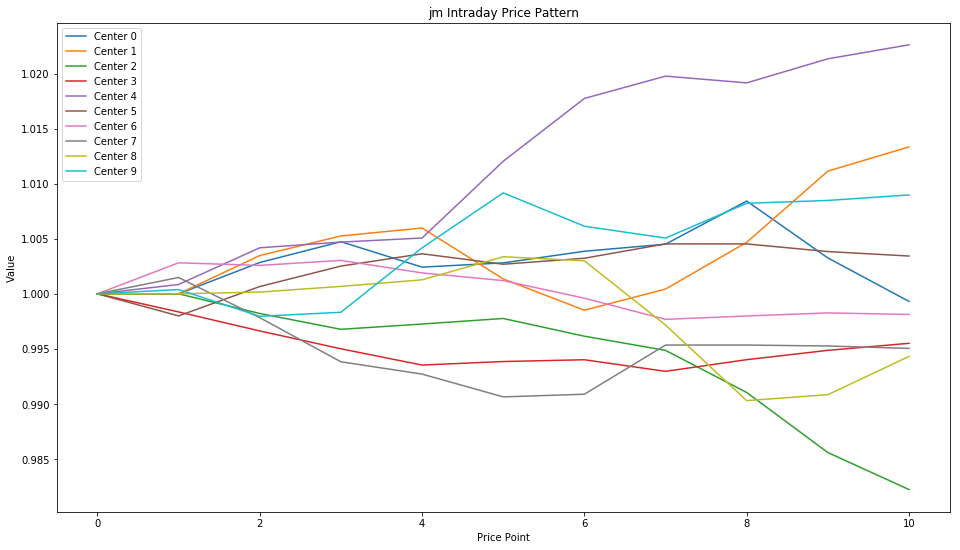

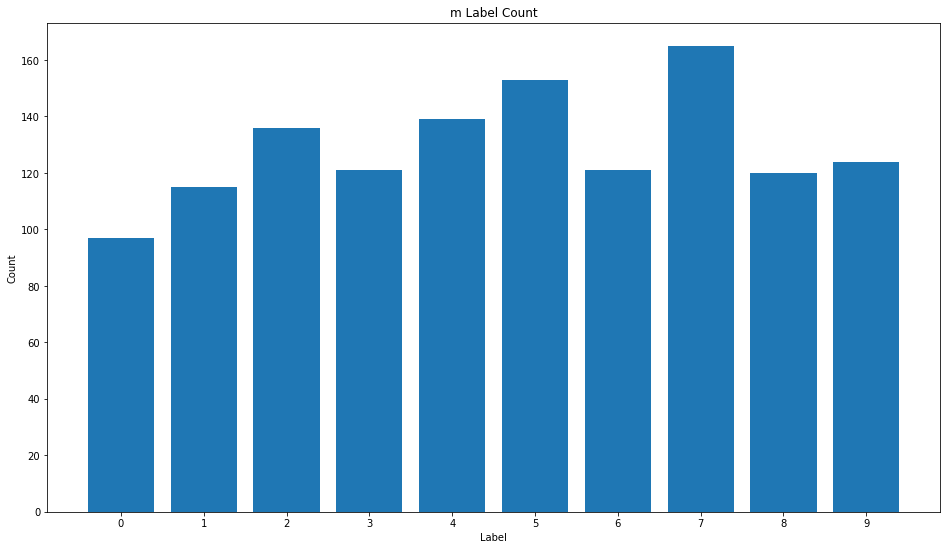

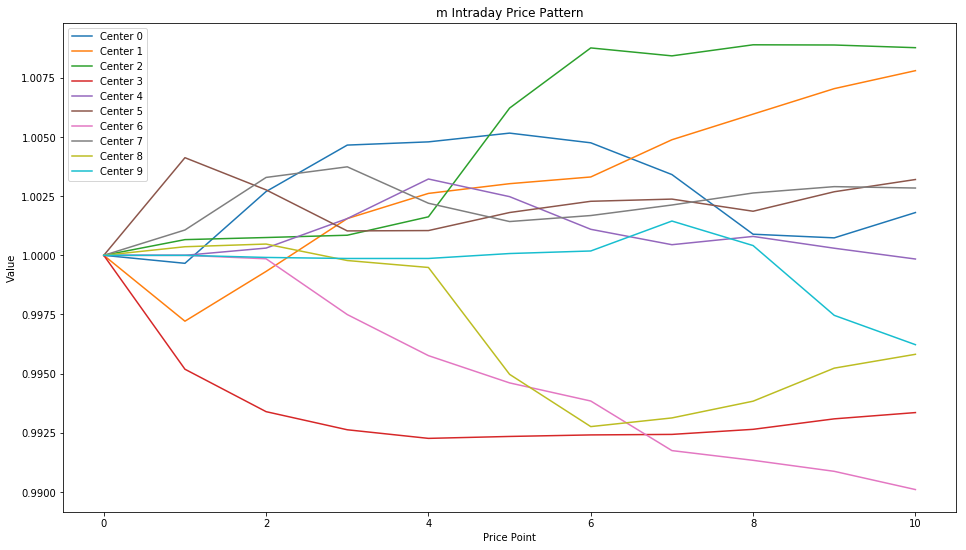

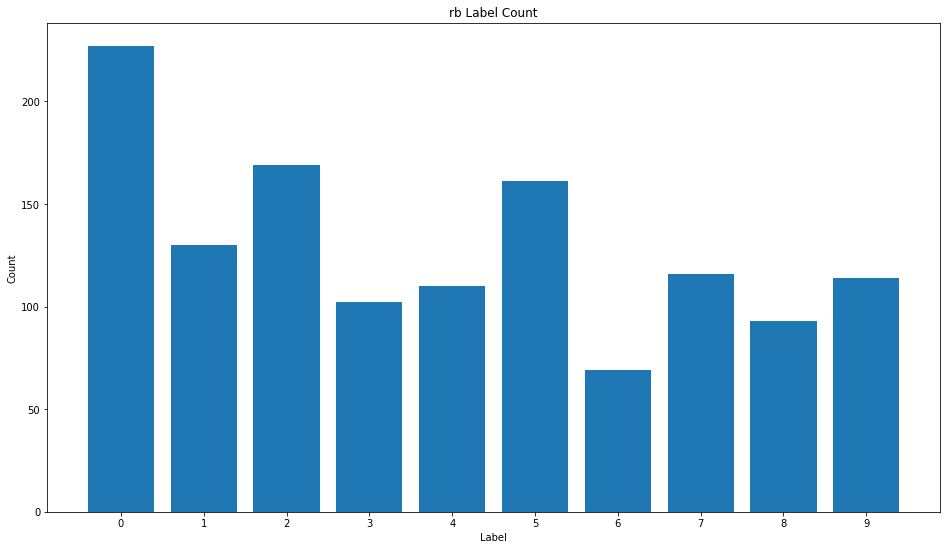

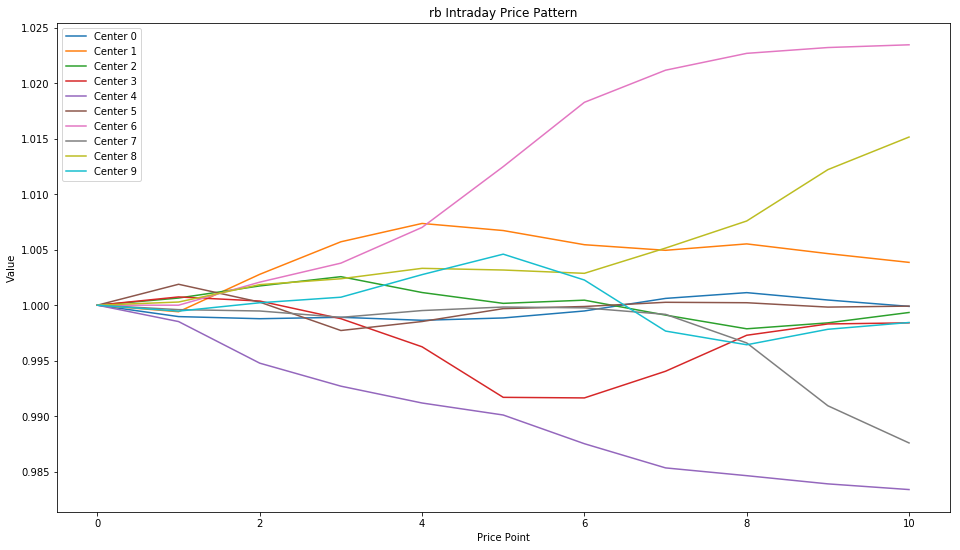

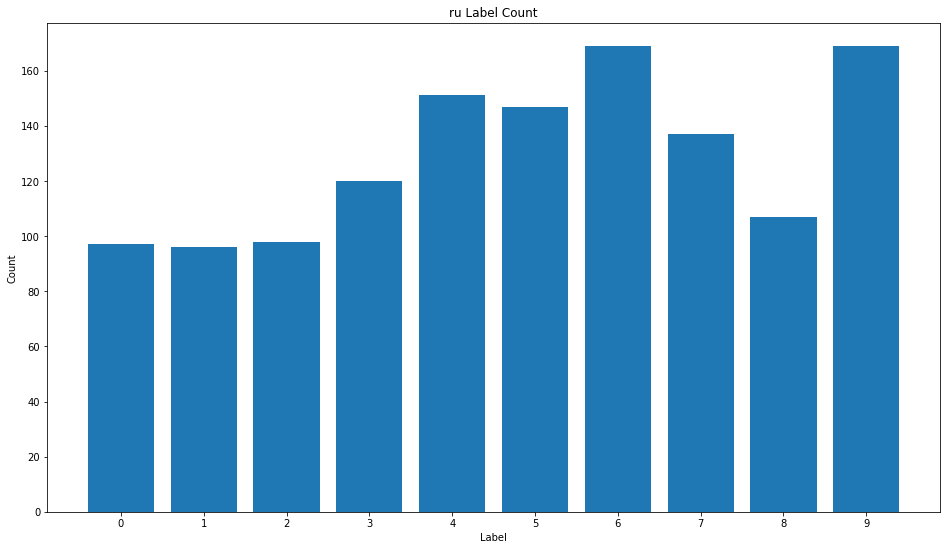

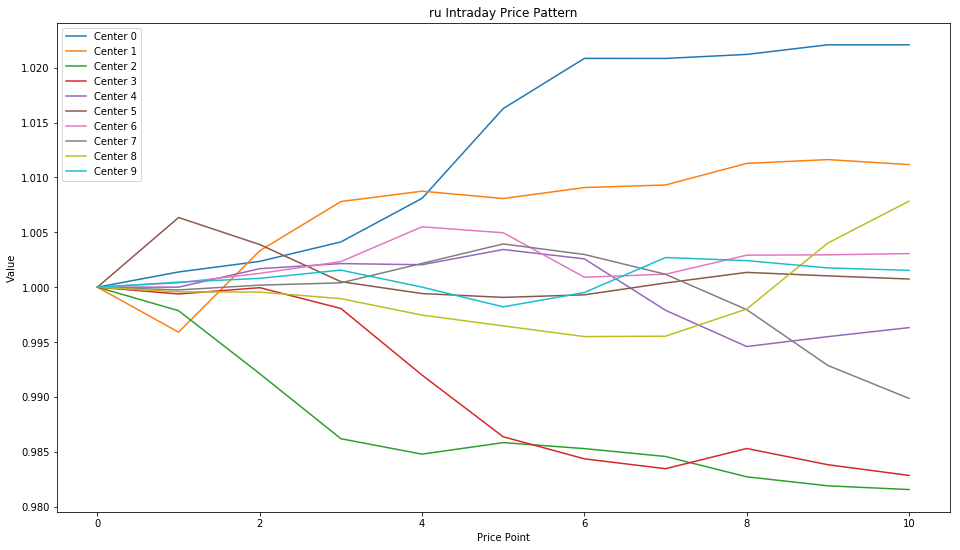

In [18]:
LabelNum = 10 #聚类的组数
TestSize = 500
PricePointNum = 8 #日内价格取多少个观测点（不包括开盘价和收盘价）至少为1
FutureList = ['ag', 'au', 'cu', 'i', 'IF','j', 'jm', 'm', 'rb', 'ru']

for future in FutureList:
    pattern_train, pattern_test = load_price_pattern_data(future, PricePointNum, 1)
    model, scaler = normalise_cluster(pattern_train, LabelNum)
    centers = scaler.inverse_transform(model.cluster_centers_)
    values = np.zeros((LabelNum, PricePointNum + 3))
    for i in range(len(centers)):
        values[i, 0] = 1.0
    for i in range(len(centers)):
        for j in range(0, len(centers[i])):
            values[i, j + 1] = values[i, j] *(1.0 + centers[i, j])
    multi_plot(values, ['Center ' + str(i) for i in range(LabelNum)], 'Price Point', 'Value', future + ' Intraday Price Pattern')